[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gdsaxton/GDAN5400/blob/main/Week%2011%20Notebooks/GDAN%205400%20-%20Week%2011%20Notebooks%20%28III%29%20-%20Feature%20Importance.ipynb)

# From Prediction to Interpretation

Up to this point, we've focused on building and comparing models — trying to reduce error and improve performance.

But good data science doesn't stop at prediction. It's just as important to ask:

> 🧠 *What can the model tell us about the data itself?*

In this final section, we’ll shift our focus from modeling to **insight**.

---

### What We'll Do in This Notebook

1. **Refit the final model** — using a clean, reproducible pipeline that includes imputation and MinMax scaling  
   (This locks in the best-performing approach we found in the previous notebook.)

2. **Plot feature importances** — to see which variables had the most influence on the model’s predictions  
   (This helps us understand what matters most in predicting house prices.)

3. **Test smaller feature sets** — to check whether we can achieve similar performance using only a few of the top features  
   (This helps us simplify the model and potentially improve efficiency and interpretability.)

---

These steps take us beyond “What’s the best model?” and into “What is the model teaching us about the data?” — which is often the most valuable part of an analysis.


---

Read in The Usual Packages and Set up Environment

In [1]:
import numpy as np
import pandas as pd

In [2]:
#http://pandas.pydata.org/pandas-docs/stable/options.html
pd.set_option('display.max_columns', None)  #Set PANDAS to show all columns in DataFrame
pd.set_option('max_colwidth', 500)

# Set pandas display precision to 3 decimal places
pd.set_option('display.precision', 3)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Housing Prices `Training` Dataset
I have uploaded the training and test datasets onto the class GitHub repository.

In [4]:
train_url = 'https://raw.githubusercontent.com/gdsaxton/GDAN5400/refs/heads/main/Housing_Prices/train.csv'
train = pd.read_csv(train_url)
print('# of rows in training dataset:', len(train), '\n')
train[:2]

# of rows in training dataset: 1460 



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


## Scaling All Numeric Features Using Pipelines

For this demonstration, we're focusing on **numeric features** because:

- Most scikit-learn preprocessing tools (like `StandardScaler` and `SimpleImputer`) work directly on numeric values.
- It allows us to demonstrate the full pipeline (imputation → scaling → modeling) without needing to encode categorical variables.
- Many regression models expect numerical input and will raise errors if given raw categorical values.

In [5]:
# Select all numeric predictors (excluding Id and target variable)
numeric_features = train.select_dtypes(include='number').columns.tolist()
numeric_features.remove('Id')
numeric_features.remove('SalePrice')

print(f"Number of numeric features: {len(numeric_features)}", '\n')
print(numeric_features)

Number of numeric features: 36 

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [6]:
X = train[numeric_features]
y = train['SalePrice']
print(X.shape, y.shape)

# Splitting training data into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Print out number of rows and columns in each of the four dataframes we just generated
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1460, 36) (1460,)
(1168, 36) (292, 36) (1168,) (292,)


### Step 1: Fit Final Random Forest Model with MinMax Scaling

In the previous notebook we identified **Random Forest with MinMax scaling** as our best-performing model (of the 8 we ran), so we'll refit it here so we can inspect and interpret its results.

We use a `Pipeline` that includes:

1. **Imputation**: We use `SimpleImputer(strategy='median')` to fill in any missing values in our numeric features. This ensures we have no `NaN` values, which Random Forest can't handle.
2. **Scaling**: We apply `MinMaxScaler()` to rescale all numeric features to a range between 0 and 1. While tree-based models like Random Forest don't strictly require scaling, we include it here for consistency and to reflect the version that gave us the best results.
3. **Model**: We use `RandomForestRegressor()` with a fixed `random_state` for reproducibility.

By combining all of this into a `Pipeline`, we ensure that our preprocessing and modeling steps are bundled together cleanly and repeatably — which is especially important when we move on to visualizations like feature importance.

---

#  Step 1: Fit a Random Forest Model with MinMax Scaling

We’ll now fit a single Random Forest model using the same settings that gave us the best performance earlier.

We use a pipeline that:
1. **Imputes** missing values using the median
2. **Scales** numeric features using `MinMaxScaler` (compresses all values to the range [0, 1])
3. Fits a **Random Forest Regressor**

This is our simplest end-to-end workflow using the 36 numeric features from the training set.

By using a `Pipeline`, we keep everything clean, organized, and ready for evaluation and interpretation.


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Preprocessing: Impute + MinMax Scale
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ]), numeric_features)
], remainder='drop')

# Pipeline with RandomForest
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'GarageArea', 'WoodDeckSF',
                                                   'OpenPorchSF',
                                                   'EnclosedPorch', ...])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# Step 2: Plot Feature Importances

Now that we’ve fitted our final Random Forest model with MinMax scaling, we can inspect which features the model considered most important for predicting `SalePrice`.

Random Forest is a tree-based model, which means it naturally computes **feature importance scores** based on how much each feature reduces error when it's used to split the data.

In this step, we:
1. Access the fitted model from the pipeline using `.named_steps['regressor']`
2. Retrieve the feature names that were passed into the model (after preprocessing) — these correspond to our original numeric variables
3. Extract feature importance scores from the fitted Random Forest
4. Sort the features by importance
5. Plot the **top 20 features** using a horizontal bar chart

This visualization helps us answer:
- Which variables are driving the predictions?
- Are the most important features what we expected?
- Could we potentially simplify the model by using only the top features?

Understanding feature importance is a crucial step toward making our models more transparent and interpretable — especially when sharing results with stakeholders.

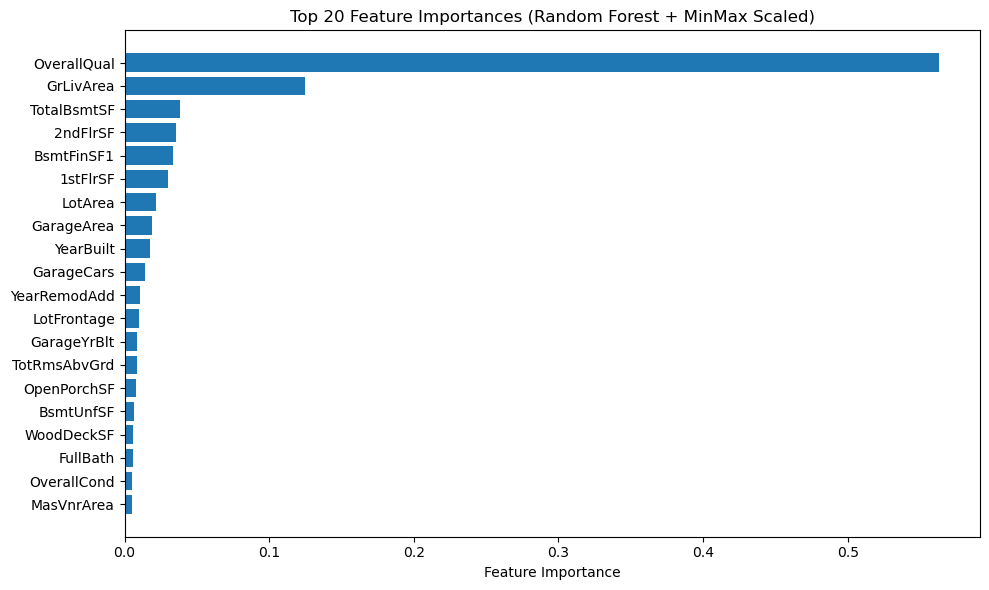

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get fitted model
rf_model = rf_pipe.named_steps['regressor']

# Get preprocessed feature names
scaled_feature_names = preprocessor.named_transformers_['num'] \
    .named_steps['imputer'] \
    .feature_names_in_

importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Plot top 20
plt.figure(figsize=(10, 6))
plt.barh(np.array(scaled_feature_names)[sorted_idx][:20][::-1],
         importances[sorted_idx][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (Random Forest + MinMax Scaled)")
plt.tight_layout()
plt.show()

#### What’s on the x-axis in the above plot?

The x-axis shows the **feature importance score** assigned by the Random Forest model. These scores:

- Reflect how often and how effectively a feature is used in the decision trees
- Are **relative** and **unitless**, but they sum to 1
- Indicate that the farther a bar extends to the right, the more **influential** that feature was in the model’s predictions

This plot helps us interpret what the model learned — and which variables are driving our results.


# Step 3: Plot RMSLE by Number of Top Features

Now that we know which features are most important to our Random Forest model, we can explore a critical question:

> **Do we really need all 36 numeric features to get good predictions?**

In this step, we evaluate model performance (using RMSLE) as we vary the number of top-ranked features used in the model — from just the single most important feature to all 36.

Here’s how it works:
1. We use the feature importances from the Random Forest model to **rank** all numeric features.
2. For each value of `N` from 1 to 36:
   - We select the top `N` features
   - We build a fresh pipeline using only those features
   - We impute missing values and scale them using MinMaxScaler
   - We train a new Random Forest model
   - We compute and store the RMSLE on the validation set
3. Finally, we plot **RMSLE vs. Number of Top Features**

This plot shows whether adding more features continues to improve the model, or if performance plateaus (or even worsens) due to noise or redundancy.

It's a great way to:
- Identify a **minimal subset** of features that gives near-optimal performance
- Reduce overfitting and improve model simplicity
- Build faster, more interpretable models

In [ ]:
from sklearn.metrics import mean_squared_log_error

# RMSLE scoring function
def rmsle_score(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(y_pred, 0)))

rmsle_by_feature_count = []

# Try models with top N features from 1 to all
for top_n in range(1, len(numeric_features) + 1):
    top_features = np.array(scaled_feature_names)[sorted_idx][:top_n].tolist()

    # Subset X_train and X_val to top features only
    X_train_sub = X_train[top_features]
    X_val_sub = X_val[top_features]

    # Define and fit pipeline
    sub_pipe = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())
            ]), top_features)
        ])),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    sub_pipe.fit(X_train_sub, y_train)
    y_pred = sub_pipe.predict(X_val_sub)
    score = rmsle_score(y_val, y_pred)

    rmsle_by_feature_count.append(score) 

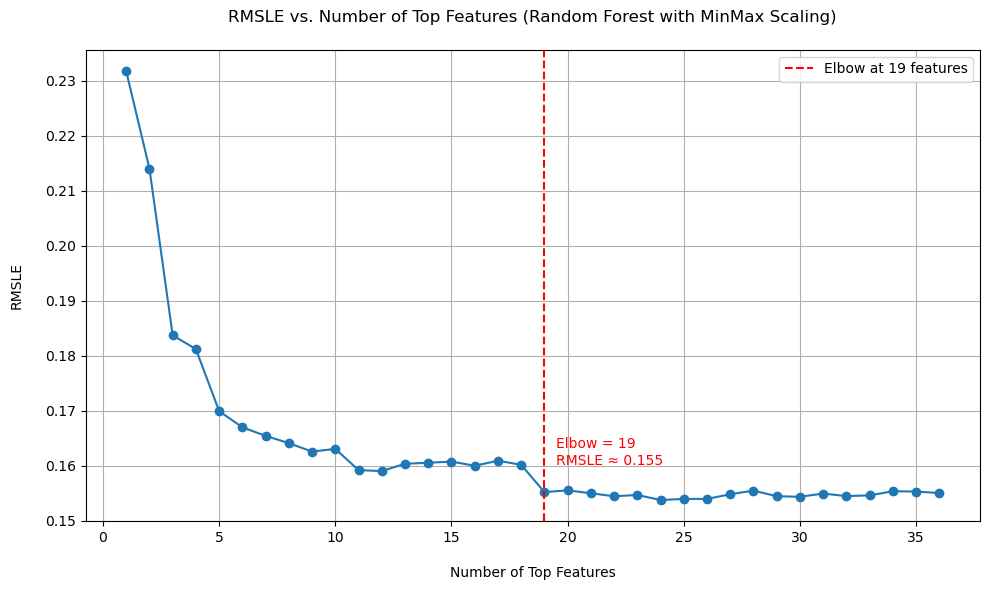

In [22]:
# Find elbow point manually or automatically
elbow_x = 19  # You can adjust this number if you see a better cutoff visually
elbow_y = rmsle_by_feature_count[elbow_x - 1]  # list index is 0-based

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmsle_by_feature_count) + 1), rmsle_by_feature_count, marker='o')
plt.axvline(x=elbow_x, color='red', linestyle='--', label=f'Elbow at {elbow_x} features')
plt.text(elbow_x + 0.5, elbow_y + 0.005, f'Elbow = {elbow_x}\nRMSLE ≈ {elbow_y:.3f}', color='red')
plt.xlabel("Number of Top Features", labelpad=15)
plt.ylabel("RMSLE", labelpad=15)
plt.title("RMSLE vs. Number of Top Features (Random Forest with MinMax Scaling)", pad=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpreting the Plot: RMSLE vs. Number of Top Features

This plot shows how model performance (RMSLE) improves as we include more of the top-ranked features in our Random Forest model.

#### Key Takeaways:

- The **first few features** (1–5) contribute the most to error reduction. These are likely the most powerful predictors of house prices.
- From about **5 to 19 features**, we see smaller, gradual improvements. This is the zone of **diminishing returns**.
- Around **19-24 features**, the RMSLE flattens out — meaning that adding more features beyond this point does not lead to better predictions.
- After about 25 features, the model may be adding **redundant or noisy variables** that don’t help and could even hurt performance slightly.

#### Lesson:

We don’t always need to use all available features. In this case, we could reduce our model from 36 features to about **19–25 top features** and still maintain nearly identical performance — with the added benefits of:
- Faster model training
- Easier interpretation
- Less risk of overfitting

This kind of analysis helps us build **simpler, smarter models**.


---

### The 'Elbow' Method for Identifying the Optimal Number of Features to Include

In modeling, more features can often lead to better predictions — **up to a point**.

But after that point, each new feature adds **less and less value**, and might even hurt the model by:

- Increasing noise or overfitting
- Slowing down training
- Making results harder to explain

That’s why we look for the **elbow** in the curve — the point where adding more features leads to **diminishing returns** in performance.

### Identifying the Elbow: Why 19 Features Makes Sense

When we plotted RMSLE (Root Mean Squared Log Error) against the number of top features used, we were looking for a point where the curve **starts to flatten** — the point of **diminishing returns**. 

---

### 🧠 What Does "Diminishing Returns" Mean Here?

If we get:
- A big drop in error by adding the first 5–10 features
- A small drop by adding features 11–20 
- Almost no change after feature 25

Then we know:
- We’re already getting most of the model’s value from the first 10–20 features
- We can safely **exclude the rest** without hurting performance

Specifically, we see that:

- RMSLE dropped significantly between 1 and 15 features.
- By the time we reached **19 features**, RMSLE had dropped to **0.155**.
- After that, the improvements were **very small** — less than 0.001 in total.
- The lowest RMSLE we saw was about **0.154**, even with all 36 features.

---

### Why 19 Is a Strong Elbow Point

Although the curve technically flattens between 22 and 24 features, we can reasonably call **19 the elbow** because:

- We're already achieving **99% of the model's best performance**
- Adding more features **only improves RMSLE by tiny fractions** (e.g., 0.0002)
- Using fewer features makes the model **simpler, faster, and easier to interpret**

---

### Why This Matters

- It helps us build **simpler, more interpretable models**
- It reduces **training time and complexity**
- It prepares us for techniques like **feature selection**, **dimensionality reduction**, or **production deployment**

In short: we're learning how to make **smarter models**, not just more complex ones. Differently put:


> **Elbow ≠ Best Performance. Elbow = Efficient Performance.**

Choosing 19 features gives us a great balance between accuracy and simplicity — and helps us avoid adding unnecessary complexity for very little gain.

---

## Summary: What We Learned

In this notebook, we shifted from building models to interpreting them — using Random Forest as our most accurate model.

### Key Takeaways:

- **Feature importances** showed which variables had the biggest impact on price predictions.
- **Performance vs. number of features** helped us see how much value each variable adds.
- The model’s performance **plateaus after about 22–24 features**, suggesting we can reduce dimensionality without sacrificing accuracy.

---

### Why This Matters

- We can **simplify the model** by focusing only on the top features.
- Simpler models are:
  - Easier to interpret
  - Faster to train and test
  - Less likely to overfit

This kind of analysis helps bridge the gap between machine learning and practical decision-making — helping us **understand** our data, not just predict with it.
